In [1]:
%matplotlib inline
import os
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import reconstruct_3d as r3d

In [2]:
name = "house"
plot = True

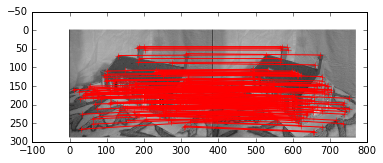

In [3]:
## Load images, K matrices and matches
data_dir = os.path.join('..', 'data', name)

# images
I1 = scipy.misc.imread(os.path.join(data_dir, "{}1.jpg".format(name)))
I2 = scipy.misc.imread(os.path.join(data_dir, "{}2.jpg".format(name)))

# K matrices
K1 = np.array(scipy.io.loadmat(os.path.join(data_dir, "{}1_K.mat".format(name)))["K"], order='C')
K2 = np.array(scipy.io.loadmat(os.path.join(data_dir, "{}2_K.mat".format(name)))["K"], order='C')

# corresponding points
# this is a N x 4 where:
# matches[i,0:2] is a point in the first image
# matches[i,2:4] is the corresponding point in the second image
matches = np.loadtxt(os.path.join(data_dir, "{}_matches.txt".format(name)))

# visualize matches (disable or enable this whenever you want)
if plot:
    fig, ax = plt.subplots()
    ax.imshow(np.concatenate([I1, I2], axis=1))
    ax.plot(matches[:, 0], matches[:, 1], 'r+')
    ax.plot(matches[:, 2] + I1.shape[1], matches[:, 3], 'r+')
    ax.plot(np.array([matches[:, 0], matches[:, 2] + I1.shape[1]]), matches[:, [1, 3]].T, 'r')

In [5]:
# compute the fundamental matrix
(F, res_err) = r3d.fundamental_matrix(matches)
print('Residual in F = {}'.format(res_err))

Residual in F = 0.3948162870821741


In [44]:
# compute the essential matrix
E = np.dot(np.dot(K2.T, F), K1)

# compute the rotation and translation matrices
(R, t) = r3d.find_rotation_translation(E)

In [53]:
# Find R2 and t2 from R, t such that largest number of points lie in front
# of the image planes of the two cameras
P1 = np.dot(K1, np.concatenate([np.eye(3), np.zeros((3, 1))], axis=1))

# the number of points in front of the image planes for all combinations
num_points = np.zeros((len(t), len(R)))

# the reconstruction error for all combinations
errs = np.empty((len(t), len(R)))

for ti, t2 in enumerate(t):
    t2 = t[ti]
    for ri, R2 in enumerate(R):
        R2 = R[ri]
        P2 = np.dot(K2, np.concatenate([R2, t2[:, None]], axis=1))

        points_3d, errs[ti, ri] = r3d.find_3d_points(matches, P1, P2)

        Z1 = points_3d[:, 2]
        Z2 = (np.dot(R2[2], points_3d.T) + t2[2]).T
        print((Z1, Z2))
        num_points[ti, ri] = np.sum((Z1 > 0) & (Z2 > 0))

j = 0 # pick one out the best combinations
(ti, ri) = np.nonzero(num_points == np.max(num_points))
print('Reconstruction error = {}'.format(errs[ti[j], ri[j]]))

(array([ 1.32727748,  1.91142825,  0.52946357,  2.66680613,  5.23240377,
        5.40023813,  6.17485571,  0.67190467,  0.64695986,  0.91719544,
        0.64202772,  0.56136333,  0.56164951,  0.57186529,  1.66814245,
        1.46928825,  2.65090894,  0.59172205,  0.62001241,  2.33694276,
        0.53022311,  0.59363263,  0.62544818,  0.64179404,  0.72538815,
        1.05953793,  5.03060137,  5.32002129,  0.90924879,  1.7375357 ,
        1.79731077,  3.34945915,  3.02748214,  1.30353564,  1.51509269,
        5.19744626,  4.24612553,  0.70445184,  0.57830308,  0.62385268,
        2.23163948,  0.65251032,  2.11550649,  2.81620634,  2.26738373,
        3.62505756,  3.12052809,  3.50576731,  0.69402987,  4.0675996 ,
        0.61953962,  2.80428249,  2.09380288,  1.28717488,  5.84704782,
        3.69706889,  2.01663021,  2.56432309,  0.6682229 ,  0.81856042,
        2.3760535 ,  2.32898314,  0.5716588 ,  0.5848935 ,  0.6254742 ,
        0.3827458 ,  0.6654401 ,  2.10300693,  2.17947468,  2.0

In [45]:
%matplotlib inline

from reconstruct_3d import reconstruct_3d

Residual in F = 0
Reconstruction error = 0.0


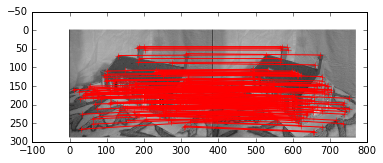

In [46]:
reconstruct_3d("house")